<a href="https://colab.research.google.com/github/ambuj-99/Financial-Models---1/blob/main/CAPM_Tesla_return_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install getFamaFrenchFactors

  Preparing metadata (setup.py) ... done
  Created wheel for bs4: filename=bs4-0.0.1-py3-none-any.whl size=1256 sha256=3d74bed3833a6a99b51bb31ba4269532627e3cdd3eca0ad64ecd7a1c917601ac
  Stored in directory: /root/.cache/pip/wheels/25/42/45/b773edc52acb16cd2db4cf1a0b47117e2f69bb4eb300ed0e70
Successfully built bs4


In [4]:
pip install seaborn


ERROR: Could not find a version that satisfies the requirement seaborne (from versions: none)
ERROR: No matching distribution found for seaborne


In [21]:
import pandas as pd
import pandas_datareader as reader
import datetime as dt
import statsmodels.api as sm
import getFamaFrenchFactors as gff
import seaborn as sns
import yfinance as yf

In [4]:
end = dt.datetime.now()
start = dt.date(end.year - 6, end.month,end.day)
ticker ='TSLA'

In [5]:
tesla_data = yf.download(ticker, start=start, end=end)['Adj Close']
tesla_data.tail()

[*********************100%%**********************]  1 of 1 completed


Date
2023-08-22    233.190002
2023-08-23    236.860001
2023-08-24    230.039993
2023-08-25    238.589996
2023-08-28    238.820007
Name: Adj Close, dtype: float64

Convert to monthly prices i.e. take the last price of each month


In [6]:
tesla_data = tesla_data.resample('1M').last()
tesla_data.head()

Date
2017-08-31    23.726667
2017-09-30    22.740000
2017-10-31    22.101999
2017-11-30    20.590000
2017-12-31    20.756666
Freq: M, Name: Adj Close, dtype: float64

In [10]:
tesla_returns = tesla_data.pct_change()
tesla_returns = tesla_returns.dropna()
tesla_returns.head()

Date
2017-09-30   -0.041585
2017-10-31   -0.028056
2017-11-30   -0.068410
2017-12-31    0.008095
2018-01-31    0.137980
Freq: M, Name: Adj Close, dtype: float64

Market Excess Return

In [12]:
ff3_monthly = pd.DataFrame(gff.famaFrench3Factor(frequency='m'))
ff3_monthly.rename(columns={'date_ff_factors':'Date'},inplace = True)
ff3_monthly.set_index('Date')
ff3_monthly.head()

,Date,Mkt-RF,SMB,HML,RF
0,1926-07-31,0.0296,-0.0256,-0.0243,0.0022
1,1926-08-31,0.0264,-0.0117,0.0382,0.0025
2,1926-09-30,0.0036,-0.0140,0.0013,0.0023
3,1926-10-31,-0.0324,-0.0009,0.0070,0.0032
4,1926-11-30,0.0253,-0.0010,-0.0051,0.0031


In [14]:
data = ff3_monthly.merge(tesla_returns,on='Date')
data.head()

,Date,Mkt-RF,SMB,HML,RF,Adj Close
0,2017-09-30,0.0251,0.0446,0.0312,0.0009,-0.041585
1,2017-10-31,0.0225,-0.0193,0.0021,0.0009,-0.028056
2,2017-11-30,0.0312,-0.0058,-0.0008,0.0008,-0.068410
3,2017-12-31,0.0106,-0.0132,0.0005,0.0009,0.008095
4,2018-01-31,0.0557,-0.0315,-0.0133,0.0012,0.137980


In [18]:
#Excess retuen on Tesla
Tsla_excess_ret = data['Adj Close'] - data['RF']
data['TSLA-RF'] = Tsla_excess_ret
data.rename(columns={'Adj Close':'TSLA'},inplace = True)
data.head()

,Date,Mkt-RF,SMB,HML,RF,TSLA,TSLA-RF
0,2017-09-30,0.0251,0.0446,0.0312,0.0009,-0.041585,-0.042485
1,2017-10-31,0.0225,-0.0193,0.0021,0.0009,-0.028056,-0.028956
2,2017-11-30,0.0312,-0.0058,-0.0008,0.0008,-0.068410,-0.069210
3,2017-12-31,0.0106,-0.0132,0.0005,0.0009,0.008095,0.007195
4,2018-01-31,0.0557,-0.0315,-0.0133,0.0012,0.137980,0.136780


Checking relation between the variables through seaborn

<Axes: xlabel='Mkt-RF', ylabel='TSLA-RF'>

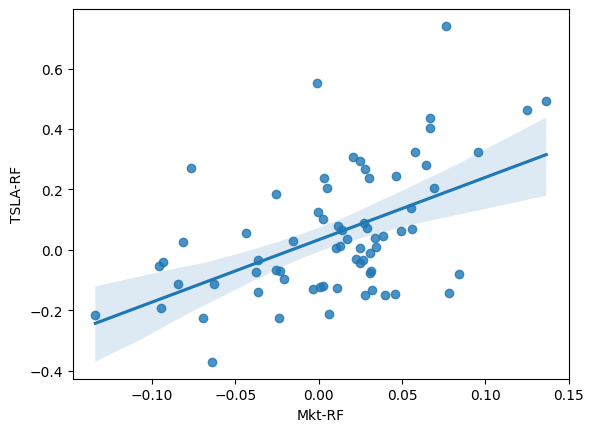

In [19]:
sns.regplot(x='Mkt-RF',y= 'TSLA-RF',data = data)

In [22]:
x = data['Mkt-RF']
y = data['TSLA-RF']
x1= sm.add_constant(x)
model = sm.OLS(y,x1)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                TSLA-RF   R-squared:                       0.269
Model:                            OLS   Adj. R-squared:                  0.258
Method:                 Least Squares   F-statistic:                     24.98
Date:                Tue, 29 Aug 2023   Prob (F-statistic):           4.31e-06
Time:                        05:04:34   Log-Likelihood:                 20.884
No. Observations:                  70   AIC:                            -37.77
Df Residuals:                      68   BIC:                            -33.27
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0331      0.022      1.495      0.140      -0.011       0.077
Mkt-RF         2.0665      0.414      4.998      0.000       1.241       2.892
==============================================================================
Omnibus:                        7.257   Durbin-Watson:                   1.676
Prob(Omnibus):                  0.027   Jarque-Bera (JB):                6.523
Skew:                           0.663   Prob(JB):                       0.0383
Kurtosis:                       3.691   Cond. No.                         19.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [24]:
# Beta for tesla is 2.0665
intercept , beta = results.params
beta
# hence tesla is twice as risky as the overall market portfolio
# Tesla's Beta is calculated by running regression of tesla's risk excess return against market's risk excess return that is market portfolio's return minus the risk free rate of return

2.0665462584652716

In [27]:
risk_free = data['RF'].mean()
market_premium = data['Mkt-RF'].mean()


0.009719999999999996

In [28]:
tesla_exp_return = risk_free + beta*market_premium
#yearly return
tesla_exp_return = tesla_exp_return * 12
tesla_exp_return

0.25533909844453206